In [2]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import re
from nltk.corpus import stopwords
import nltk
import string
import matplotlib.pyplot as plt
import random
%matplotlib inline

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn import decomposition, ensemble
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
#from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix

import joblib


### Part 1  Loading testing data 

In [52]:
testdf = pd.read_csv('ibc_testingdata_040219.csv')
print(len(testdf))

18127


In [4]:
testdf['deleted_reason'].unique()

array([nan, 'family_history', 'phoneORaddressORother_number',
       'not_relevant', 'negation', 'other', 'not_doctors_note',
       'preventative_screening', 'incorrect_acronym', 'medical_history',
       'incorrect_version'], dtype=object)

In [53]:
testdf.head()

,Unnamed: 0,Unnamed: 0.1,chart_id,code_id,text,start_offset,end_offset,deleted_reason,deleted,label,...,25char,50char,75char,10word_after,10word_before,50word_after,50word_before,flag,text75,cleaned_data
0,120,120,002807250_159402158A_2016_001,J440,j44.0,27422,27427,NaN,NaN,agreed,...,with acute bronchitis - J44.0 Onychomycosis...,uctive chronic bronchitis with acute bronchiti...,disorder - Z72.0 Obstructive chronic bronch...,"[['Onychomycosis', '-', 'B35.1', 'Rash-', 'R21...","[['disorder', '-', 'Z72.0', 'Obstructive', 'ch...","[['Onychomycosis', '-', 'B35.1', 'Rash-', 'R21...","[['cancer,', 'mental', 'illness,', 'thyroid', ...",0,disorder - Z72.0 Obstructive chronic bronch...,disorder z720 obstructive chronic bronchitis a...
1,164,164,002811494_174328162A_2016_001,E785,e78.5,44080,44085,NaN,NaN,agreed,...,K21.9) Hyperlipidemia (E78.5) Mitral regur...,05) Esophageal reflux (K21.9) Hyperlipidem...,initis (J31.0) Cough (R05) Esophageal refl...,"[[')', 'Mitral', 'regurgitation', '(134.0)', '...","[['Chronic', 'rhinitis', '(J31.0)', 'Cough', '...","[[')', 'Mitral', 'regurgitation', '(134.0)', '...","[['prior', 'study', 'there', 'is', 'no', 'chan...",0,initis (J31.0) Cough (R05) Esophageal refl...,initis j310 cough r05 esophageal reflux k219 h...
2,165,165,002811494_174328162A_2016_001,E785,e78.5,154372,154377,NaN,NaN,agreed,...,K21.9) Hyperlipidemia (E78.5) Mitral regur...,05) Esophageal reflux (K21.9) Hyperlipidem...,initis (J31.0) Cough (R05) Esophageal refl...,"[[')', 'Mitral', 'regurgitation', '(134.0)', '...","[['Chronic', 'rhinitis', '(J31.0)', 'Cough', '...","[[')', 'Mitral', 'regurgitation', '(134.0)', '...","[['prior', 'study', 'there', 'is', 'no', 'chan...",0,initis (J31.0) Cough (R05) Esophageal refl...,initis j310 cough r05 esophageal reflux k219 h...
3,166,166,002811494_174328162A_2016_001,G35,g35,44140,44143,NaN,NaN,agreed,...,0) Multiple sclerosis (G35) Neurogenic bla...,itral regurgitation (134.0) Multiple scleros...,yperlipidemia (E78.5) Mitral regurgitation (...,"[[')', 'Neurogenic', 'bladder', '(N31.9)', 'Pa...","[['reflux', '(K21.9)', 'Hyperlipidemia', '(E78...","[[')', 'Neurogenic', 'bladder', '(N31.9)', 'Pa...","[['Leftward', 'axis', 'and', 'delay', 'in', 'R...",0,yperlipidemia (E78.5) Mitral regurgitation (...,yperlipidemia e785 mitral regurgitation 1340 m...
4,167,167,002811494_174328162A_2016_001,G35,g35,61708,61711,NaN,NaN,agreed,...,0) *Multiple sclerosis (G35) Neurogenic bla...,itral fegurgithtion (134.0) *Multiple scleros...,yperlipidemia (E78.5) Mitral fegurgithtion (...,"[[')', 'Neurogenic', 'bladder', '(N31.9)', 'Pa...","[['reflux', '(K21.9)', 'Hyperlipidemia', '(E78...","[[')', 'Neurogenic', 'bladder', '(N31.9)', 'Pa...","[['progression', 'in', 'the', 'anteroseptal', ...",0,yperlipidemia (E78.5) Mitral fegurgithtion (...,yperlipidemia e785 mitral fegurgithtion 1340 m...


In [6]:
list1=testdf['chart_id'].unique()
print(len(list1))   # 
print(len(set(list1)))  # number of unique charts in this dataset

2000
2000


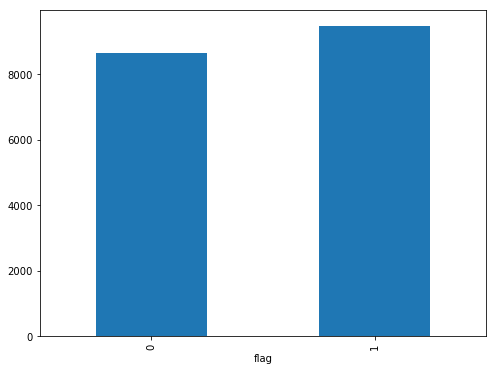

flag
0    8655
1    9472
dtype: int64

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
testdf.groupby('flag').flag.count().plot.bar(ylim=0)
plt.show()
testdf.groupby(['flag']).size()                 # 0 is agreed+added, 1 is deleted 

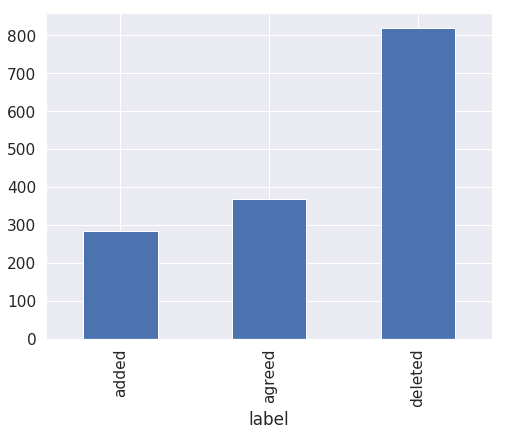

label
added      284
agreed     367
deleted    818
dtype: int64

In [89]:
fig = plt.figure(figsize=(8,6))
seltestdf.groupby('label').flag.count().plot.bar(ylim=0)
plt.show()
seltestdf.groupby(['label']).size()  

In [26]:
select_list=pd.read_csv('df_filterdeletions_134charts.csv')  # select 134 charts only

In [28]:
sellist=select_list['chart_id'].tolist()

In [29]:
sellist

['IBXRMA2018_MULT_1220457850010001_HMK_160322553D_ANNA_MAZZATENTA_003643542_2017',
 'ibxrma2018_mult_1217178090010001_hmk_201220138a_rosie_dean_002810825_2017',
 'IBXRMA2018_MULT_1217165980010001_HMK_186363477A_ELIZABETH_ALLEGAR_003387287_2017',
 'IBXRMA2018_MULT_1217261140010001_HMK_185465335A_NANCY_PAPPADAKIS_003387287_2017',
 'IBXRMA2018_MULT_1220828210010001_HMK_174329674A_LASZLO_CSETENYI_002805178_2017',
 'IBXRMA2018_MULT_1218359500010001_HMK_166369492A_RONALD_ESHLEMAN_002809845_2017',
 'IBXRMA2018_MULT_1198880400010001_HMK_199420187A_CLINTON_WAX_002806316_2017',
 'IBXRMA2018_MULT_1201804890010001_HMK_219066178A_SARA_PATTERSON_002804060_2017',
 'IBXRMA2018_MULT_1259795960010001_HMK_135408001A_BARBARA_MARABELLO_002822847_2017',
 'IBXRMA2018_MULT_1220828210010001_HMK_174329674A_LASZLO_CSETENYI_002805178_2017',
 'IBXRMA2018_MULT_1217844060010001_HMK_209243890A_DOLORES_FRASSETTA_003387287_2017',
 'IBXRMA2018_MULT_1230730510010001_HMK_194369542A_LARRY_ESHBACH_003020819_2017_20180626093

In [54]:
seltestdf=testdf[testdf["chart_id"].isin(sellist)==True]
print(len(seltestdf))

1469


In [39]:
addata=pd.read_csv('df_filterdeletions_134charts.csv')

### Part 2. Tokenizing the test data

####  word tokenizing first

In [13]:
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pickle

Using TensorFlow backend.


In [14]:
testdf.flag.value_counts()

1    9472
0    8655
Name: flag, dtype: int64

In [18]:
with open("../../picklefolder_ngrams/temp_4deletionmodels_refreshed/keras_tokenizer_embeddings_0328.pickle", "rb") as f:
   tokenizer = pickle.load(f)    # lOAD tokenizer

In [90]:

max_len = 70

In [20]:
word_index = tokenizer.word_index
word_index

{'disease': 1,
 'hypertension': 2,
 'history': 3,
 'chronic': 4,
 'diabetes': 5,
 'unspecified': 6,
 'hyperlipidemia': 7,
 'type': 8,
 'patient': 9,
 'kidney': 10,
 'mellitus': 11,
 'without': 12,
 'essential': 13,
 'disorder': 14,
 'heart': 15,
 'stable': 16,
 'screening': 17,
 'primary': 18,
 'cancer': 19,
 'plan': 20,
 'family': 21,
 'cholesterol': 22,
 'depression': 23,
 'artery': 24,
 'current': 25,
 'stage': 26,
 'continue': 27,
 'use': 28,
 'pain': 29,
 'atrial': 30,
 'coronary': 31,
 'assessment': 32,
 'benign': 33,
 'medical': 34,
 'left': 35,
 'normal': 36,
 'onset': 37,
 'blood': 38,
 'right': 39,
 'hypercholesterolemia': 40,
 'pulmonary': 41,
 'visit': 42,
 'i10': 43,
 'diabetic': 44,
 'mild': 45,
 'fibrillation': 46,
 'active': 47,
 'osteoporosis': 48,
 'problem': 49,
 'reflux': 50,
 'hypothyroidism': 51,
 'failure': 52,
 'past': 53,
 'anxiety': 54,
 'mixed': 55,
 'care': 56,
 'problems': 57,
 'mg': 58,
 'due': 59,
 'high': 60,
 'htn': 61,
 'reviewed': 62,
 'present': 63,


In [22]:
# below is the  testing dataset 2000 charts
# 
print(len(testdf))

# tokenize the test dataset
sequences = tokenizer.texts_to_sequences(testdf['cleaned_data'].values)
#word_index = tokenizer.word_index
#print('Found %s unique tokens.' % len(word_index))
testX1 = pad_sequences(sequences, maxlen=max_len)
y_test1 = testdf['flag']
print(testX1.shape,y_test1.shape)

18127
(18127, 70) (18127,)


In [31]:
# tokenize the test dataset 134 charts
sequences2 = tokenizer.texts_to_sequences(seltestdf['cleaned_data'].values)
#word_index = tokenizer.word_index
#print('Found %s unique tokens.' % len(word_index))

testX2 = pad_sequences(sequences2, maxlen=max_len)
y_test2 = seltestdf['flag']
print(testX2.shape,y_test2.shape)

(1469, 70) (1469,)


### Loading the lstm model and predict

In [23]:
# load the lstm model
model2=joblib.load('../picklefolder_ngrams/DeleteReason_biclass_Mar2819_lstm.pickle') 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


Test accuracy is 0.84625144811607
[[7233 1422]
 [1365 8107]]
Test accuracy is 0.84625144811607
                            precision    recall  f1-score   support

Class 0:agreement+addition       0.84      0.84      0.84      8655
          Class 1:deletion       0.85      0.86      0.85      9472

                 micro avg       0.85      0.85      0.85     18127
                 macro avg       0.85      0.85      0.85     18127
              weighted avg       0.85      0.85      0.85     18127

threshold accuracy_score precision recall f1_score tn  fn  fp  tp
0.1 0.7343189716996745  1   0.67  0.96 4185 346 4470 9126
0.2 0.8000220665305897  1   0.75  0.93 5687 657 2968 8815
0.3 0.8271638991559552  1   0.79  0.90 6429 907 2226 8565
0.4 0.8370386715948585  1   0.82  0.88 6858 1157 1797 8315
0.5 0.84625144811607  1   0.85  0.86 7233 1365 1422 8107
0.6 0.8482926021956197  1   0.87  0.83 7512 1607 1143 7865
0.7 0.8470237766867105  1   0.90  0.80 7765 1883 890 7589
0.8 0.841286478733381

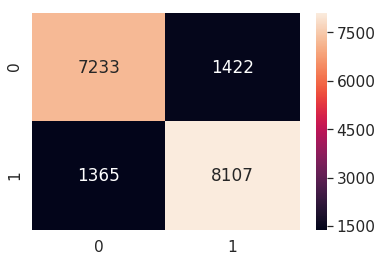

In [24]:
# testing on the 2000 charts

predictiont2 = model2.predict(testX1)

finallabelt2= (predictiont2 > 0.5).astype(np.int) 

print('Test accuracy is {}'.format(accuracy_score(y_test1, finallabelt2)))

conf_mat = confusion_matrix(y_test1, finallabelt2)
print(conf_mat)
df_cm = pd.DataFrame(conf_mat, range(2),
                  range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt='d')

print('Test accuracy is {}'.format(accuracy_score(y_test1, finallabelt2)))
target_names = ['Class 0:agreement+addition', 'Class 1:deletion']
print(classification_report(y_test1, finallabelt2, target_names=target_names))

# now try different threshold
print("threshold accuracy_score precision recall f1_score tn  fn  fp  tp")
for thres in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:  #no, cannot use it, this is for binary class only
    prediction2t = np.where(predictiont2 > thres, 1, 0)
        #print(prediction)
    conf_mat = confusion_matrix(y_test1, prediction2t)
    tn, fp, fn, tp = conf_mat.ravel()
    report = classification_report(y_test1,prediction2t)
    lines = report.split('\n')
    #print(lines[2])
    row_data = lines[3].split('     ')
    print(thres,accuracy_score(y_test1, prediction2t),row_data[2],row_data[3],row_data[4], tn, fn, fp, tp)

Test accuracy is 0.8400272294077604
[[552  99]
 [136 682]]
Test accuracy is 0.8400272294077604
                            precision    recall  f1-score   support

Class 0:agreement+addition       0.80      0.85      0.82       651
          Class 1:deletion       0.87      0.83      0.85       818

                 micro avg       0.84      0.84      0.84      1469
                 macro avg       0.84      0.84      0.84      1469
              weighted avg       0.84      0.84      0.84      1469

threshold accuracy_score precision recall f1_score tn  fn  fp  tp
0.1 0.7488087134104833  1   0.70  0.95 320 38 331 780
0.2 0.7957794417971409  1   0.77  0.91 423 72 228 746
0.3 0.8175629680054459  1   0.81  0.89 477 94 174 724
0.4 0.8332198774676651  1   0.84  0.86 522 116 129 702
0.5 0.8400272294077604  1   0.87  0.83 552 136 99 682
0.6 0.8352620830496936  1   0.89  0.80 573 164 78 654
0.7 0.8277739959155889  1   0.92  0.76 595 197 56 621
0.8 0.8182437031994554  1   0.93  0.72 609 225 42

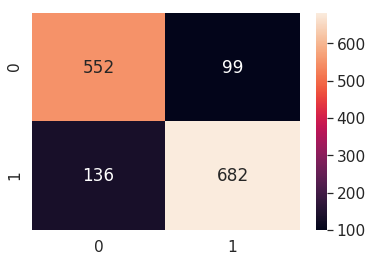

In [32]:
# testing on the 134 charts

predictiont = model2.predict(testX2)

finallabelt= (predictiont > 0.5).astype(np.int) 

print('Test accuracy is {}'.format(accuracy_score(y_test2, finallabelt)))

conf_mat = confusion_matrix(y_test2, finallabelt)
print(conf_mat)
df_cm = pd.DataFrame(conf_mat, range(2),
                  range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt='d')

print('Test accuracy is {}'.format(accuracy_score(y_test2, finallabelt)))
target_names = ['Class 0:agreement+addition', 'Class 1:deletion']
print(classification_report(y_test2, finallabelt, target_names=target_names))

# now try different threshold
print("threshold accuracy_score precision recall f1_score tn  fn  fp  tp")
for thres in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:  #no, cannot use it, this is for binary class only
    prediction = np.where(predictiont > thres, 1, 0)
        #print(prediction)
    conf_mat = confusion_matrix(y_test2, prediction)
    tn, fp, fn, tp = conf_mat.ravel()
    report = classification_report(y_test2,prediction)
    lines = report.split('\n')
    #print(lines[2])
    row_data = lines[3].split('     ')
    print(thres,accuracy_score(y_test2, prediction),row_data[2],row_data[3],row_data[4], tn, fn, fp, tp)

In [44]:
len(predictiont)

1469

In [34]:
finallabelt

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [56]:
seltestdf['prob']=predictiont

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [57]:
seltestdf.head()

,Unnamed: 0,Unnamed: 0.1,chart_id,code_id,text,start_offset,end_offset,deleted_reason,deleted,label,...,50char,75char,10word_after,10word_before,50word_after,50word_before,flag,text75,cleaned_data,prob
321,6332,6332,IBXRMA2018_MULT_1163978900010001_HMK_185569588...,E782,MIXED HYPERLIPIDEMIA,4082,4102,NaN,0.0,agreed,...,CD10-I70.203) COPD (ICD-493.20) (ICD10-J44.9...,BOTH LEGS (ICD-440.20) (ICD10-I70.203) COPD ...,"[['(ICD-272.2)', '(ICD10-E78.2)', 'ESSENTIAL',...","[['Problems:', 'ATHEROSCLEROSIS', 'OF', 'BOTH'...","[['(ICD-272.2)', '(ICD10-E78.2)', 'ESSENTIAL',...","[['(LISINOPRIL)', 'one', 'tablet', 'daily', 'P...",0,BOTH LEGS (ICD-440.20) (ICD10-I70.203) COPD ...,legs icd44020 icd10i70203 copd icd49320 icd10j...,0.030844
322,6333,6333,IBXRMA2018_MULT_1163978900010001_HMK_185569588...,I10,ESSENTIAL HYPERTENSION,4131,4153,NaN,0.0,agreed,...,MIXED HYPERLIPIDEMIA (ICD-272.2) (ICD10-E78.2...,D-493.20) (ICD10-J44.9) MIXED HYPERLIPIDEMIA...,"[['(ICD-401.1)', '(ICD10-I10)', 'TRICUSPID', '...","[['LEGS', '(ICD-440.20)', '(ICD10-I70.203)', '...","[['(ICD-401.1)', '(ICD10-I10)', 'TRICUSPID', '...","[['PROLIDA', '4-1', '%', 'PTCH', '(LIDOCAINE-M...",0,D-493.20) (ICD10-J44.9) MIXED HYPERLIPIDEMIA...,d49320 icd10j449 mixed hyperlipidemia icd2722 ...,0.040653
323,6334,6334,IBXRMA2018_MULT_1163978900010001_HMK_185569588...,I10,I10,4173,4176,NaN,0.0,agreed,...,78.2) ESSENTIAL HYPERTENSION (ICD-401.1) (IC...,EMIA (ICD-272.2) (ICD10-E78.2) ESSENTIAL HYP...,"[[')', 'TRICUSPID', 'VALVE', 'DISORDERS', 'SPE...","[['(ICD-493.20)', '(ICD10-J44.9)', 'MIXED', 'H...","[[')', 'TRICUSPID', 'VALVE', 'DISORDERS', 'SPE...","[['(LIDOCAINE-MENTHOL)', 'every', 'six', 'mont...",0,EMIA (ICD-272.2) (ICD10-E78.2) ESSENTIAL HYP...,emia icd2722 icd10e782 essential hypertension ...,0.068764
324,6335,6335,IBXRMA2018_MULT_1163978900010001_HMK_185569588...,I70203,I70.203,4037,4044,NaN,0.0,agreed,...,ATHEROSCLEROSIS OF BOTH LEGS (ICD-440.20) (IC...,"ever, D.O.. Problems: ATHEROSCLEROSIS OF B...","[[')', 'COPD', '(ICD-493.20)', '(ICD10-J44.9)'...","[['Samuel', 'Stever,', 'D.O..', 'Problems:', '...","[[')', 'COPD', '(ICD-493.20)', '(ICD10-J44.9)'...","[['5', 'MG', 'TABS', '(LISINOPRIL)', 'one', 't...",0,"ever, D.O.. Problems: ATHEROSCLEROSIS OF B...",ever problems atherosclerosis legs icd44020 ic...,0.184418
325,6336,6336,IBXRMA2018_MULT_1163978900010001_HMK_185569588...,J449,COPD,4048,4052,NaN,0.0,agreed,...,ROSIS OF BOTH LEGS (ICD-440.20) (ICD10-I70.203...,Problems: ATHEROSCLEROSIS OF BOTH LEGS (I...,"[['(ICD-493.20)', '(ICD10-J44.9)', 'MIXED', 'H...","[['Samuel', 'Stever,', 'D.O..', 'Problems:', '...","[['(ICD-493.20)', '(ICD10-J44.9)', 'MIXED', 'H...","[['5', 'MG', 'TABS', '(LISINOPRIL)', 'one', 't...",0,Problems: ATHEROSCLEROSIS OF BOTH LEGS (I...,problems atherosclerosis legs icd44020 icd10i7...,0.118873


In [48]:
len(addata)

19665

In [49]:
addata1=addata[addata['model_name']=='consolidated_model']
len(addata1)

7878

In [59]:
merged=pd.merge(addata1,seltestdf,on=['chart_id','start_offset'],how='inner')

In [60]:
len(merged)

823

In [73]:
merged['prob_x'] = pd.to_numeric(merged['prob_x']) 

In [62]:
merged[['chart_id','start_offset','prob_x','prob_y']].head(100)

,chart_id,start_offset,prob_x,prob_y
0,IBXRMA2018_MULT_1259795960010001_HMK_135408001...,16408,0.9800000190734863,0.979624
1,IBXRMA2018_MULT_1218102580010001_HMK_187245452...,38446,0.6100000143051147,0.061069
2,IBXRMA2018_MULT_1217429630010001_HMK_165481734...,13283,0.9800000190734863,0.956187
3,IBXRMA2018_MULT_1217049240010001_HMK_054423873...,39868,0.6100000143051147,0.138575
4,IBXRMA2018_MULT_1217637910010001_HMK_180306029...,3143,0.7799999713897705,0.658583
5,IBXRMA2018_MULT_1216749980010001_HMK_136309377...,14031,0.7300000190734863,0.468923
6,IBXRMA2018_MULT_1216995180010001_HMK_229543808...,56717,0.9200000166893005,0.992882
7,IBXRMA2018_MULT_1216706530010001_HMK_182305617...,11016,0.9900000095367432,0.990318
8,IBXRMA2018_MULT_1259795960010001_HMK_135408001...,30962,0.8700000047683716,0.541561
9,IBXRMA2018_MULT_1217091600010001_HMK_166745370...,43645,0.7200000286102295,0.614857


In [82]:
sel1=merged[['chart_id','start_offset','prob_x','prob_y']][(merged['prob_y'])<0.5]

In [83]:
sel1

,chart_id,start_offset,prob_x,prob_y
1,IBXRMA2018_MULT_1218102580010001_HMK_187245452...,38446,0.61,0.061069
3,IBXRMA2018_MULT_1217049240010001_HMK_054423873...,39868,0.61,0.138575
5,IBXRMA2018_MULT_1216749980010001_HMK_136309377...,14031,0.73,0.468923
11,IBXRMA2018_MULT_1217974490010001_HMK_204181760...,21269,0.53,0.214928
16,ibxrma2018_mult_1213057200010001_hmk_188289327...,70073,0.67,0.296057
18,IBXRMA2018_MULT_1216943020010001_HMK_204408304...,65827,0.52,0.215776
24,IBXRMA2018_MULT_1217471440010001_HMK_168309480...,38962,0.59,0.043671
27,IBXRMA2018_MULT_1217974490010001_HMK_204181760...,23570,0.51,0.338175
33,ibxrma2018_mult_1216738010010001_hmk_178188458...,14967,0.76,0.218158
34,ibxrma2018_mult_1216738010010001_hmk_178188458...,14843,0.68,0.072490


In [78]:
len(merged[(merged['prob_x'])<0.5])

0

In [87]:
sel2=merged[['chart_id','start_offset','prob_x','prob_y']][abs(merged['prob_y']-merged['prob_x'])>0.001]

In [88]:
len(sel2)

802

In [74]:
merged.dtypes

Unnamed: 0_x        int64
chart_id           object
code_id_x          object
end_offset_x        int64
label_x             int64
model_name         object
prob_x            float64
start_offset        int64
submissionId       object
Unnamed: 0_y        int64
Unnamed: 0.1        int64
code_id_y          object
text               object
end_offset_y        int64
deleted_reason     object
deleted           float64
label_y            object
15char             object
25char             object
50char             object
75char             object
10word_after       object
10word_before      object
50word_after       object
50word_before      object
flag                int64
text75             object
cleaned_data       object
prob_y            float32
dtype: object